In [1]:
from jax import jit, vmap, random
import jax.numpy as np
import numpy as onp
import jax

# enable float 64
from jax.config import config
config.update('jax_enable_x64', True)

In [2]:
import pandas as pd
import datetime

def create_df_response(samples, time,  quantiles = [50, 80, 95], forecast_horizon=27, date_init=None, sample_freq="D", dates=None, use_future=False):
    """ Create a dataframe with the quantiles of the model and forecast if provided

    Args:
        samples: Samples of the variable to create the dataframe
        time:    [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """

    if samples.shape[-1] != time:
        raise Exception("Samples second dimension must be equal to time")

    if dates is not None:
        dates_fitted = dates
    elif date_init is not None and sample_freq is not None:
        dates_fitted = pd.date_range(pd.to_datetime(date_init), periods=time, freq=sample_freq)

    else:
        dates_fitted   = list(range(time))
        dates_forecast = list(range(time, time+forecast_horizon))

    dates = dates_fitted
    types = ['estimate']*len(dates_fitted)

    if use_future:
        dates += list(dates_forecast)
        types += ['forecast']*len(dates_forecast)

    results_df  = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)

    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q
        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response



In [3]:
# https://github.com/google/jax/issues/10144
def transition(xi, τ, dt=1):
    kb    = np.maximum(1.0 - np.exp(-τ*dt), 0)
    pop   = onp.random.binomial(onp.int64(xi), kb )
    return jax.device_put(pop)

def checkpopvars(x, pop):
    return np.minimum(np.maximum(x, 0), pop)

def f(x, dt, β, γ, N):
    """
    Process model
    """

    S = x.at[0, :].get()
    I = x.at[1, :].get()
    R = x.at[2, :].get()
    C = x.at[3, :].get()

    s2i = transition(S, β * I / N, dt)
    i2r = transition(I, γ, dt)

    S  = S - s2i
    I  = I + s2i - i2r
    R  = R + i2r
    C  = s2i

    return checkpopvars(np.array([S, I, R, C]), N)

def g(x):
    """
    Observational model
    """
    return x.at[3, :].get()



In [8]:
N = 1000

β = 0.3 # days
γ = 1/7 # days

# initial conditions
I0 = N * 0.01
S0 = N - I0
R0 = 0
C0 = 0

ens = 500
x0  = np.ones((4, ens)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)

T  = 35
dt = 1

x_sim = x0

x_sim = np.full((4, T, ens), np.nan)
x_sim = x_sim.at[:, 0, :].set(x0)

for t in range(1, T):
    x     = sir(x_sim.at[:, t-1, :].get(), 1, β, γ, N)
    x_sim = x_sim.at[:, t, :].set(x)


In [11]:
C.shape

(35, 500)

In [46]:
S =  x_sim.at[0, :, :].get(); S_df = create_df_response(S.T, T)
I =  x_sim.at[1, :, :].get(); I_df = create_df_response(I.T, T)
R =  x_sim.at[2, :, :].get(); R_df = create_df_response(R.T, T)
C =  x_sim.at[3, :, :].get(); C_df = create_df_response(C.T, T)

k = jax.random.PRNGKey(1)
obs_use = np.maximum(C.at[:, 300].get() + np.squeeze(jax.random.normal(k, shape=(T, 1)) *5))


In [47]:
S_df.index.shape, obs_use.shape, C.at[:, 300].get().shape,  jax.random.normal(k, shape=(T, 1)).shape

((35,), (35,), (35,), (35, 1))

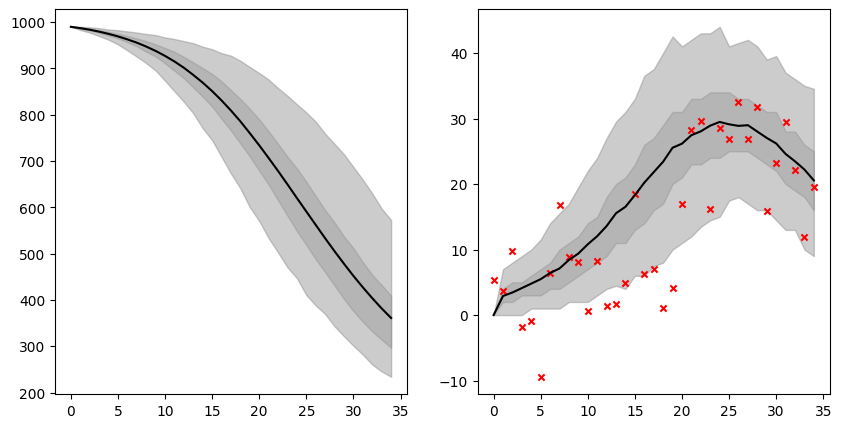

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(S_df.index, S_df['mean'], label='S', color="k")
ax[0].fill_between(S_df.index, S_df['low_95'], S_df['high_95'], alpha=0.4, color="gray")
ax[0].fill_between(S_df.index, S_df['low_50'], S_df['high_50'], alpha=0.3, color="gray")

ax[1].plot(C_df.index, C_df['mean'], label='S', color="k")
ax[1].fill_between(C_df.index, C_df['low_95'], C_df['high_95'], alpha=0.4, color="gray")
ax[1].fill_between(C_df.index, C_df['low_50'], C_df['high_50'], alpha=0.3, color="gray")
ax[1].scatter(S_df.index, obs_use, color="red", marker="x", s=20)


In [7]:
def eakf(x, y_sim, y, oev, return_gain=False):
    """ Ensemble Adjustment Kalman Filter

    Args:
        x    : State space at time t.
        y_sim: Simulated observation.
        y    : Measured observation.
        oev  : Observation error variance.
        return_gain (bool, optional): If true return the gain of the filter. Defaults to False.

    Returns:
        xpost: Posterior estimate of state space.
        obspost: Posterior estimate of observation.
    """
    num_vars, num_ens = x.shape
    prior_mean_ct     = y_sim.mean(-1, keepdims=True)  # Average over ensemble members
    prior_var_ct      = y_sim.var(-1, keepdims=True)   # Compute variance over ensemble members

    post_var_ct   = prior_var_ct * oev / (prior_var_ct + oev)
    post_mean_ct  = post_var_ct * (prior_mean_ct/prior_var_ct + y / oev)
    alpha         = oev / (oev+prior_var_ct); alpha = alpha**0.5
    dy            = post_mean_ct + alpha*( y_sim - prior_mean_ct ) - y_sim

    A       = np.cov(x, y_sim)
    covars  = A.at[:-1, -1].get()
    rr      = covars / prior_var_ct
    dx      = np.dot( np.expand_dims(rr, -1), np.expand_dims(dy, 0))
    xpost   = x     + dx
    obspost = y_sim + dy

    if return_gain:
        return xpost, obspost, dx
    else:
        return xpost, obspost

def geometric_cooling(if_iters, cooling_factor=0.9):
    alphas = cooling_factor**np.arange(if_iters)
    return alphas**2

def hyperbolic_cooling(if_iters, cooling_factor=0.9):
    alphas = 1/(1+cooling_factor*np.arange(if_iters))
    return alphas

def cooling(num_iteration_if, type_cool="geometric", cooling_factor=0.9):
    if type_cool=="geometric":
        return geometric_cooling(num_iteration_if, cooling_factor=cooling_factor)
    elif type_cool=="hyperbolic":
        return hyperbolic_cooling(num_iteration_if, cooling_factor=cooling_factor)
